In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
import anndata2ri

In [2]:
import warnings
anndata2ri.activate()
%load_ext rpy2.ipython

sc.settings.verbosity = 0
warnings.filterwarnings("ignore")

C:\Users\yjyang027\Miniconda3\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
def Xct_DB(specis = 'Human'):
    if specis == 'mouse':
        LR = pd.read_csv('https://raw.githubusercontent.com/yjgeno/Ligand-Receptor-Pairs/master/Mouse/Mouse-2020-Jin-LR-pairs.csv')
    else:
        LR = pd.read_csv('https://raw.githubusercontent.com/yjgeno/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')
    receptors = LR['receptor'].str.split('_', expand=True)
    receptors.columns = ['rec_A', 'rec_B', 'rec_C']
    LRs = pd.concat([LR[['pathway_name', 'ligand']], receptors], axis=1)
    del LR
    return LRs

In [4]:
LRs = Xct_DB()
LRs

,pathway_name,ligand,rec_A,rec_B,rec_C
0,TGFb,TGFB1,TGFbR1,R2,None
1,TGFb,TGFB2,TGFbR1,R2,None
2,TGFb,TGFB3,TGFbR1,R2,None
3,TGFb,TGFB1,ACVR1B,TGFbR2,None
4,TGFb,TGFB1,ACVR1C,TGFbR2,None
...,...,...,...,...,...
2000,TIGIT,TIGIT,MGI:107741,None,None
2001,VCAM,ITGA4_ITGB1,VCAM1,None,None
2002,VCAM,ITGA9_ITGB1,VCAM1,None,None
2003,VCAM,ITGA4_ITGB7,VCAM1,None,None


In [5]:
LR = pd.read_csv('https://raw.githubusercontent.com/yjgeno/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')
#LR.head()

In [6]:
LR.shape

(2005, 11)

In [7]:
receptors = LR['receptor'].str.split('_', expand=True)
receptors.columns = ['rec_A', 'rec_B', 'rec_C']

In [8]:
LRs = pd.concat([LR[['pathway_name', 'ligand']], receptors], axis=1)
LRs.head()

,pathway_name,ligand,rec_A,rec_B,rec_C
0,TGFb,TGFB1,TGFbR1,R2,None
1,TGFb,TGFB2,TGFbR1,R2,None
2,TGFb,TGFB3,TGFbR1,R2,None
3,TGFb,TGFB1,ACVR1B,TGFbR2,None
4,TGFb,TGFB1,ACVR1C,TGFbR2,None


In [9]:
#iFIB[:, iFIB.var_names.isin(['CXCL12'])].shape

In [10]:
%%R

library(Seurat)

R[write to console]: Attaching SeuratObject



In [11]:
%%R

load(url("https://ndownloader.figshare.com/files/25950872")) 
data.input = data_humanSkin$data # input normalized data matrix
meta = data_humanSkin$meta # a dataframe of cell metadata

In [12]:
%%R -o labels

cell.use = rownames(meta)[meta$condition == "LS"] # extract the cell names from disease data
data.input = data.input[, cell.use]
meta = meta[cell.use, ]
labels <- as.vector(meta$labels)
#unique(meta$labels) # check the cell labels

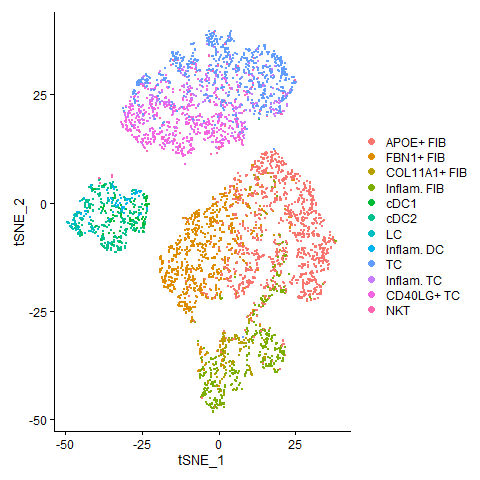

In [13]:
%%R 

set.seed(42)
LS <- CreateSeuratObject(data.input, project = 'LS', meta.data = meta)
Idents(LS) <- LS$labels
LS <- FindVariableFeatures(LS, nfeatures=3000, verbose = F)
LS <- ScaleData(LS, verbose = F) 
LS <- RunPCA(LS, verbose = F)
LS <- RunTSNE(LS)
TSNEPlot(LS)
#VariableFeaturePlot(object = LS)

R[write to console]: When using repel, set xnudge and ynudge to 0 for optimal results



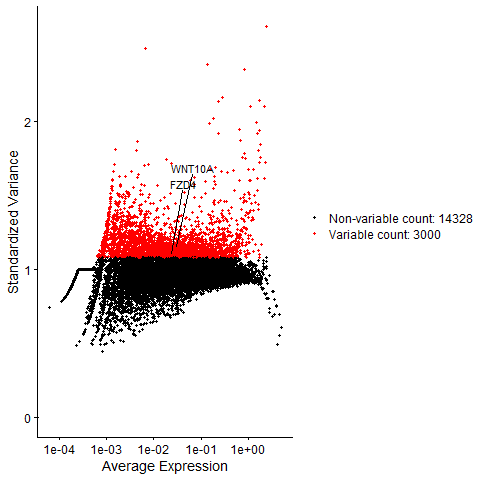

In [14]:
%%R
top <- head(VariableFeatures(LS), 50)
#png('HVG_examples.png', width = 4000, height = 4000, res = 300)
plot1 <- VariableFeaturePlot(object = LS)
LabelPoints(plot = plot1, points = c('WNT10A', 'FZD4'), repel = TRUE, xnudge=0.3, ynudge=0.5, max.overlaps = Inf)

#CombinePlots(plots = list(plot1, plot2))
#dev.off()

In [15]:
%%R -o counts -o HVGenes -o Genes -o Cells

counts <- GetAssayData(LS, slot = 'data')
Genes <- rownames(counts)
HVGenes <- rownames(GetAssayData(LS, slot = 'scale.data'))
Cells <- colnames(counts)


In [16]:
from scipy.sparse import csr_matrix
counts = csr_matrix.toarray(counts)

In [17]:
counts.shape

(17328, 5011)

### log data

In [18]:
ada = AnnData(counts.T)
ada.obs['barcodes'] = np.array(Cells)
ada.obs['ident'] = np.array(labels)
ada.var['gene_symbols'] = np.array(Genes)

ada.obs_names = ada.obs['barcodes']
ada.var_names = ada.var['gene_symbols']
#print(ada.isview)
ada = ada[:, ada.var_names.isin(HVGenes)].copy() #Not ArrayView

ada

AnnData object with n_obs × n_vars = 5011 × 3000
    obs: 'barcodes', 'ident'
    var: 'gene_symbols'

### Xct

In [19]:
ada.obs['ident'].unique()

array(['Inflam. FIB', 'FBN1+ FIB', 'APOE+ FIB', 'COL11A1+ FIB', 'cDC2',
       'LC', 'Inflam. DC', 'cDC1', 'CD40LG+ TC', 'Inflam. TC', 'TC',
       'NKT'], dtype=object)

In [20]:
CellA = 'Inflam. FIB'
CellB = 'Inflam. DC'

In [21]:
def Xct_init(ada, CellA, CellB, DB, verbose = False):
    result = {}
    AB = ada[ada.obs['ident'].isin([CellA, CellB]), :]
    A = AB[AB.obs['ident'] == CellA, :]
    B = AB[AB.obs['ident'] == CellB, :]
    
    l_exp = []
    l_var = []
    for l in DB['ligand']:
        if l not in np.array(A.var_names):
            l_exp.append(np.nan)
            l_var.append(np.nan)
        else:
            l_exp.append(np.mean(A[:, A.var_names.isin([l])].X))
            l_var.append(np.var(A[:, A.var_names.isin([l])].X))
    result['l_exp'] = l_exp
    result['l_var'] = l_var
    
    for rec in ['rec_A', 'rec_B', 'rec_C']:
        r_exp = []
        r_var = []
        for r in DB[rec]:
            if r not in np.array(B.var_names):
                r_exp.append(np.nan)
                r_var.append(np.nan)
            else:
                r_exp.append(np.mean(B[:, B.var_names.isin([r])].X)) #mean expression of L and R
                r_var.append(np.var(B[:, B.var_names.isin([r])].X))
        result['{}_exp'.format(rec)] = r_exp
        result['{}_var'.format(rec)] = r_var
    print(result.keys())

    LRs_Xct = DB.copy() 
    LRs_Xct = pd.concat([LRs_Xct, pd.DataFrame.from_dict(result)], axis=1)
    mask1 = np.invert(LRs_Xct[['l_exp', 'rec_A_exp']].isna().any(axis=1)) # remove NA
    mask2 = (LRs_Xct['l_exp'] > 0) & (LRs_Xct['rec_A_exp'] > 0) # remove 0 for original LR
    LRs_Xct = LRs_Xct[mask1 & mask2]
    if verbose:
        print('Selected {} LR pairs'.format(LRs_Xct.shape[0]))

    #LRs_Xct['rec_exp'] = LRs_Xct[['rec_A_exp', 'rec_B_exp', 'rec_C_exp']].max(axis=1) #mean for R
    #LRs_Xct['rec_var'] = LRs_Xct[['rec_A_var', 'rec_B_var', 'rec_C_var']].max(axis=1) #var for R

    return LRs_Xct
    

In [22]:
def Xct_pmt(ada, CellA, CellB, Ref, verbose = False):
    result = {}
    AB = ada[ada.obs['ident'].isin([CellA, CellB]), :]
    
    #np.random.seed(42)
    labels_pmt = np.random.permutation(AB.obs['ident'])
    AB.obs['ident'] = labels_pmt
    if verbose:
        print('Cell A and B permutated')
    #print(AB.obs['ident'][:30].unique(), AB.obs['ident'][-30:].unique()) #check
            
    A = AB[AB.obs['ident'] == CellA, :]
    B = AB[AB.obs['ident'] == CellB, :]
    #print(A.shape, B.shape)
   
    l_exp = []
    l_var = []
    for l in Ref['ligand']:
        if l not in np.array(A.var_names):
            l_exp.append(0)
            l_var.append(0)
        else:
            l_exp.append(np.mean(A[:, A.var_names.isin([l])].X))
            l_var.append(np.var(A[:, A.var_names.isin([l])].X))
    result['l_exp'] = l_exp
    result['l_var'] = l_var
    
    for rec in ['rec_A', 'rec_B', 'rec_C']:
        r_exp = []
        r_var = []
        for r in Ref[rec]:
            if r not in np.array(B.var_names):
                r_exp.append(0)
                r_var.append(0)
            else:
                r_exp.append(np.mean(B[:, B.var_names.isin([r])].X)) #mean expression of L and R
                r_var.append(np.var(B[:, B.var_names.isin([r])].X))
        result['{}_exp'.format(rec)] = r_exp
        result['{}_var'.format(rec)] = r_var
    #print(result.keys()) 
    result = pd.DataFrame.from_dict(result)
    assert len(result) == len(Ref)
    return result
  

In [23]:
def Xct_Score(df, method = 0):
    lig = ['l_exp', 'l_var']
    rec = ['rec_A_exp', 'rec_B_exp', 'rec_C_exp', 'rec_A_var', 'rec_B_var', 'rec_C_var']
    if set(rec).issubset(df.columns):
        exp_R = np.array(df[rec[:3]].max(axis=1)) #mean for R
        var_R = np.array(df[rec[3:]].max(axis=1)) #var for R
        exp_L = np.array(df[lig[0]])
        var_L = np.array(df[lig[1]])
        if method == 0:
            S = exp_L * exp_R        
        elif method == 1:
            S = (exp_L**2 + var_L)*(exp_R**2 + var_R)
        
        return S
    else:
        print('No columns for all receptors')

In [24]:
def Xct_Scores(ada, CellA, CellB, LRs_ref, s = 0, n = 100): #s: score method, permute n times
    scores = []
    for _ in range(n):
        LRs_pmt = Xct_pmt(ada, CellA, CellB, Ref = LRs_ref, verbose = False)
        scores.append(Xct_Score(df = LRs_pmt, method = s))

    assert all(len(i) == len(LRs_ref) for i in scores) #check if equal len of ref LR pairs
    return np.array(scores).T  #transpose for further looping

In [25]:
def Xct_PermuTest(orig_score, scores, p = 0.05):
    enriched_i = []
    pvals = []
    counts = []
    for i, dist in enumerate(scores):
        count = sum(orig_score[i] > value for value in dist)
        pval = 1- count/len(dist)
        pvals.append(pval)
        counts.append(count)
        
        if pval < p:
            enriched_i.append(i)           
    
    return enriched_i, pvals, counts

In [26]:
LRs_ref = Xct_init(ada, CellA, CellB, DB = LRs, verbose = True)
LRs_ref.head()

dict_keys(['l_exp', 'l_var', 'rec_A_exp', 'rec_A_var', 'rec_B_exp', 'rec_B_var', 'rec_C_exp', 'rec_C_var'])
Selected 14 LR pairs


,pathway_name,ligand,rec_A,rec_B,rec_C,l_exp,l_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var
93,GDF,GDF10,ACVR1B,ACVR2A,None,0.003259453,0.0051314095,0.030192526,0.07292709,0.09422065,0.17683919,NaN,NaN
96,GDF,GDF11,ACVR1B,ACVR2B,None,0.025238533,0.06397318,0.030192526,0.07292709,NaN,NaN,NaN,NaN
121,ACTIVIN,INHBA,ACVR1B,ACVR2A,None,0.04554484,0.08360612,0.030192526,0.07292709,0.09422065,0.17683919,NaN,NaN
122,ACTIVIN,INHBA,ACVR1B,ACVR2B,None,0.04554484,0.08360612,0.030192526,0.07292709,NaN,NaN,NaN,NaN
645,CCL,CCL19,CCR7,None,None,1.7382643,5.539186,1.6885129,1.9415792,NaN,NaN,NaN,NaN


In [27]:
LRs_pmt = Xct_pmt(ada, CellA, CellB, Ref = LRs_ref, verbose = False)
LRs_pmt.head()

Trying to set attribute `.obs` of view, copying.


,l_exp,l_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var
0,0.0,0.0,0.023697145,0.044924363,0.09183571,0.16762681,0,0
1,0.025238533,0.06397318,0.023697145,0.044924363,0,0,0,0
2,0.12381514,0.3004283,0.023697145,0.044924363,0.09183571,0.16762681,0,0
3,0.12381514,0.3004283,0.023697145,0.044924363,0,0,0,0
4,1.5131633,5.061634,0.27408552,0.6624718,0,0,0,0


In [43]:
orig_Scores = Xct_Score(df = LRs_ref)
orig_Scores

array([ArrayView(0.00030711), ArrayView(0.00076202),
       ArrayView(0.00429126), ArrayView(0.00137511),
       ArrayView(2.93508177), ArrayView(0.08582168),
       ArrayView(1.93340975), ArrayView(0.00116124),
       ArrayView(0.00203294), ArrayView(0.00022944),
       ArrayView(0.00304068), ArrayView(0.01618934), ArrayView(0.0054117),
       ArrayView(0.00059757)], dtype=object)

In [44]:
pmt_Scores = Xct_Score(df = LRs_pmt)
pmt_Scores

array([ArrayView(0.), ArrayView(0.00059808), ArrayView(0.01137065),
       ArrayView(0.00293407), ArrayView(0.41473616),
       ArrayView(0.01211441), ArrayView(0.1445426), ArrayView(0.00711147),
       ArrayView(0.00046756), ArrayView(0.00355359),
       ArrayView(0.00306089), ArrayView(0.01537586),
       ArrayView(0.00523183), ArrayView(0.00069809)], dtype=object)

In [30]:
Scores = Xct_Scores(ada, CellA, CellB, LRs_ref = LRs_ref, n=10)
Scores.shape

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


(14, 10)

In [31]:
enriched, pvals, counts = Xct_PermuTest(orig_Scores, Scores)
enriched

[4, 5, 6, 8]

In [32]:
LRs_Enriched = LRs_ref.iloc[enriched, :]
LRs_Enriched

,pathway_name,ligand,rec_A,rec_B,rec_C,l_exp,l_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var
645,CCL,CCL19,CCR7,None,None,1.7382643,5.539186,1.6885129,1.9415792,NaN,NaN,NaN,NaN
646,CCL,CCL21,CCR7,None,None,0.05082678,0.100430116,1.6885129,1.9415792,NaN,NaN,NaN,NaN
711,CXCL,CXCL12,CXCR4,None,None,1.4257646,2.7257175,1.3560512,1.5149305,NaN,NaN,NaN,NaN
825,CD137,TNFSF9,TNFRSF9,None,None,0.0058077816,0.009628484,0.35003668,0.49893814,NaN,NaN,NaN,NaN


### method2

In [39]:
orig_Scores = Xct_Score(df = LRs_ref, method=1)
orig_Scores[:5]

array([ArrayView(0.00095496), ArrayView(0.00477073),
       ArrayView(0.01591229), ArrayView(0.00632653),
       ArrayView(41.02871768)], dtype=object)

In [40]:
Scores = Xct_Scores(ada, CellA, CellB, LRs_ref = LRs_ref, s = 1, n=10)
Scores.shape

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


(14, 10)

In [41]:
enriched, pvals, counts = Xct_PermuTest(orig_Scores, Scores)
enriched

[4, 5, 6, 8]

In [42]:
LRs_Enriched = LRs_ref.iloc[enriched, :]
LRs_Enriched

,pathway_name,ligand,rec_A,rec_B,rec_C,l_exp,l_var,rec_A_exp,rec_A_var,rec_B_exp,rec_B_var,rec_C_exp,rec_C_var
645,CCL,CCL19,CCR7,None,None,1.7382643,5.539186,1.6885129,1.9415792,NaN,NaN,NaN,NaN
646,CCL,CCL21,CCR7,None,None,0.05082678,0.100430116,1.6885129,1.9415792,NaN,NaN,NaN,NaN
711,CXCL,CXCL12,CXCR4,None,None,1.4257646,2.7257175,1.3560512,1.5149305,NaN,NaN,NaN,NaN
825,CD137,TNFSF9,TNFRSF9,None,None,0.0058077816,0.009628484,0.35003668,0.49893814,NaN,NaN,NaN,NaN


In [ ]:
def vis(orig_Scores, Scores, i, LRs = LRs_ref, density = False): #index i in LRs_Selected
    print('LR pair: {} - {}'.format(LRs.iloc[i]['ligand'], LRs.iloc[i]['rec_A']))
    plt.hist(Scores[i], density = density)
    plt.axvline(x = orig_Scores[i], color = 'r')
    plt.show()

In [ ]:
vis(orig_Scores, Scores, 0, density = False)